## SCTransform

A Single-Cell RNA Sequencing Transform Method.

Use regularized negative binomial regression to normalize `UMI` express matrix.

Before we explore the `SCTransform` method, let's see what classic normalization method `Log-Normalization` does.

[2022-11-28 01:56:57][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run normalize_total...
[2022-11-28 01:56:57][Stereo][4495][140093126739776][st_pipeline][35][INFO]: normalize_total end, consume time 0.3151s.
[2022-11-28 01:56:57][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run log1p...
[2022-11-28 01:56:57][Stereo][4495][140093126739776][st_pipeline][35][INFO]: log1p end, consume time 0.1586s.


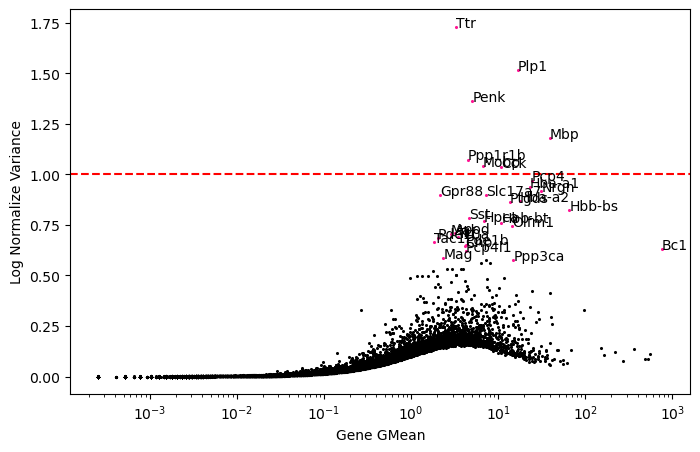

In [1]:
import sys
sys.path.insert(0, "/mnt/d/projects/stereopy_dev/stereopy/")
import stereo as st
import pandas as pd
import numpy as np

data = st.io.read_ann_h5ad("/mnt/d/projects/stereopy_dev/demo_data/raw.h5ad")
data.sparse2array()

gmean = np.exp(np.log(data.exp_matrix.T + 1).mean(1)) - 1

data.tl.raw_checkpoint()
data.tl.normalize_total(target_sum=1e4)
data.tl.log1p()

log_normalize_result = pd.DataFrame([gmean, data.exp_matrix.T.var(1)], index=['gmean', 'log_normalize_variance'], columns=data.gene_names).T

from stereo.algorithm.sctransform.plotting import plot_log_normalize_var
_ = plot_log_normalize_var(log_normalize_result)

After log-normalization, we can see lowly expressed gene contribute just a little variance in this sample.

[2022-11-28 01:57:02][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run sctransform...
[2022-11-28 01:57:02][Stereo][4495][140093126739776][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2022-11-28 01:57:05][Stereo][4495][140093126739776][vst][114][INFO]: gene-cell umi shape (17668, 2696), n_genes 2000 n_cells 2696
[2022-11-28 01:57:13][Stereo][4495][140093126739776][vst][127][INFO]: get_model_pars finished, cost 5.8638389110565186 seconds
[2022-11-28 01:57:15][Stereo][4495][140093126739776][vst][297][INFO]: ksmooth finished, cost 0.7479567527770996 seconds
[2022-11-28 01:57:15][Stereo][4495][140093126739776][vst][145][INFO]: reg_model_pars finished, cost 1.5955235958099365 seconds
[2022-11-28 01:57:16][Stereo][4495][140093126739776][vst][170][INFO]: pearson_residual cost 1.0976481437683105 seconds
[2022-11-28 01:57:21][Stereo][4495][140093126739776][vst][192][INFO]: umi_corrected cost 5.459706544876099 seconds
[2022-11-28 

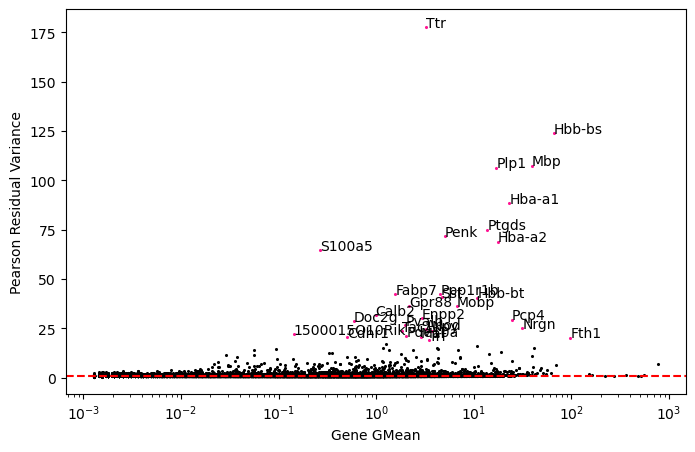

In [2]:
import sys
sys.path.insert(0, "/mnt/d/projects/stereopy_dev/stereopy/")
import stereo as st

data = st.io.read_ann_h5ad("/mnt/d/projects/stereopy_dev/demo_data/raw.h5ad")
data.tl.sctransform(res_key='sctransform', inplace=True, filter_hvgs=True)

from stereo.algorithm.sctransform.plotting import plot_residual_var
_ = plot_residual_var(data.tl.result['sctransform'])

After `SCTransform`, genes express matrix is transform from raw counts to Pearson residual.

Different with `Log`, normalization method `SCTransform` balances the all genes' variance contribution, which means that not only highly expressed genes will make sense, so do the lowly express genes.

Let take some genes from a real dataset after normalization with `SCTransform`, and see their variance contribution compare to the same dataset normalized with `Log`.

[2022-11-28 01:01:21][Stereo][4223][140453991548736][st_pipeline][32][INFO]: start to run sctransform...
[2022-11-28 01:01:21][Stereo][4223][140453991548736][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2022-11-28 01:01:24][Stereo][4223][140453991548736][vst][114][INFO]: gene-cell umi shape (17668, 2696), n_genes 2000 n_cells 2696
[2022-11-28 01:01:36][Stereo][4223][140453991548736][vst][127][INFO]: get_model_pars finished, cost 9.515921115875244 seconds
[2022-11-28 01:01:37][Stereo][4223][140453991548736][vst][297][INFO]: ksmooth finished, cost 0.5630338191986084 seconds
[2022-11-28 01:01:37][Stereo][4223][140453991548736][vst][145][INFO]: reg_model_pars finished, cost 1.6619033813476562 seconds
[2022-11-28 01:01:39][Stereo][4223][140453991548736][vst][170][INFO]: pearson_residual cost 1.4400138854980469 seconds
[2022-11-28 01:01:45][Stereo][4223][140453991548736][vst][192][INFO]: umi_corrected cost 6.3170013427734375 seconds
[2022-11-28 

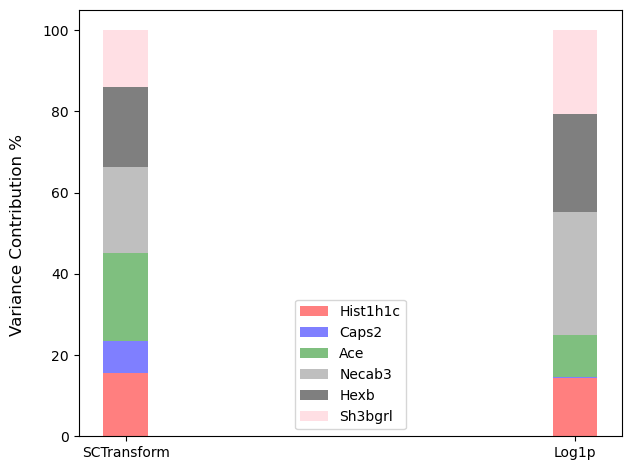

In [7]:
import sys
sys.path.insert(0, "/mnt/d/projects/stereopy_dev/stereopy/")
import stereo as st
import pandas as pd
import numpy as np

data = st.io.read_ann_h5ad("/mnt/d/projects/stereopy_dev/demo_data/raw.h5ad")
from stereo.algorithm.sctransform.plotting import plot_genes_var_contribution
plot_genes_var_contribution(data)

`Caps2` contribute very little to this experiment.

[2022-11-28 01:31:54][Stereo][4223][140453991548736][st_pipeline][32][INFO]: start to run sctransform...
[2022-11-28 01:31:55][Stereo][4223][140453991548736][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2022-11-28 01:31:59][Stereo][4223][140453991548736][vst][114][INFO]: gene-cell umi shape (17668, 2696), n_genes 2000 n_cells 2696
[2022-11-28 01:32:06][Stereo][4223][140453991548736][vst][127][INFO]: get_model_pars finished, cost 5.668118476867676 seconds
[2022-11-28 01:32:08][Stereo][4223][140453991548736][vst][297][INFO]: ksmooth finished, cost 0.47142505645751953 seconds
[2022-11-28 01:32:08][Stereo][4223][140453991548736][vst][145][INFO]: reg_model_pars finished, cost 1.3063850402832031 seconds
[2022-11-28 01:32:09][Stereo][4223][140453991548736][vst][170][INFO]: pearson_residual cost 1.1077744960784912 seconds
[2022-11-28 01:32:14][Stereo][4223][140453991548736][vst][192][INFO]: umi_corrected cost 4.967328786849976 seconds
[2022-11-28 

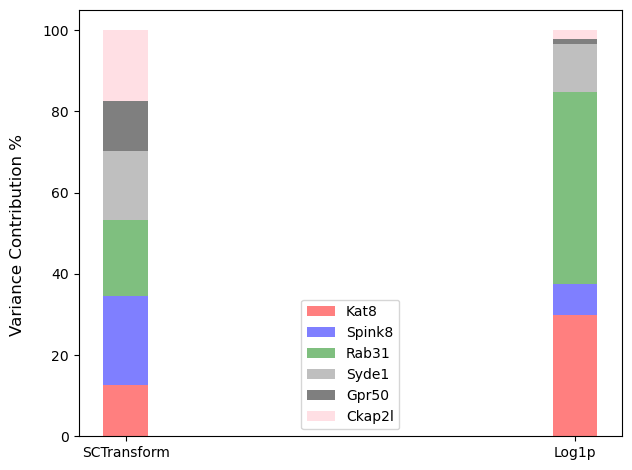

In [10]:
plot_genes_var_contribution(data)

To eliminate contingency, we pick another 6 genes from `SCTransform`'s result, and the result show that the genes' variances are stable.

More contribution from lowly expressed genes, might help us to focus on tiny difference between two cells, which can not be found before because of `Log`'s over shrinking sometimes.

For further exploration, let's try clustering method apply to these result.

In [13]:
import sys
sys.path.insert(0, "/mnt/d/projects/stereopy_dev/stereopy/")

import stereo as st
import time

data_sct = st.io.read_gef('/mnt/d/projects/stereopy_dev/demo_data/SS200000135TL_D1/SS200000135TL_D1.gef')
data_sct.tl.cal_qc()
data_sct.tl.sctransform(res_key='sctransform', inplace=True, filter_hvgs=True)
data_sct.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data_sct.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)
data_sct.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap', init_pos='spectral', spread=2.0)
data_sct.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

[2022-11-28 02:23:11][Stereo][4495][140093126739776][reader][546][INFO]: read_gef begin ...
[2022-11-28 02:23:13][Stereo][4495][140093126739776][reader][619][INFO]: the matrix has 9004 cells, and 25523 genes.
[2022-11-28 02:23:14][Stereo][4495][140093126739776][reader][627][INFO]: read_gef end.
[2022-11-28 02:23:14][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run cal_qc...
[2022-11-28 02:23:14][Stereo][4495][140093126739776][st_pipeline][35][INFO]: cal_qc end, consume time 0.2775s.
[2022-11-28 02:23:14][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run sctransform...
[2022-11-28 02:23:15][Stereo][4495][140093126739776][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2022-11-28 02:23:23][Stereo][4495][140093126739776][vst][114][INFO]: gene-cell umi shape (22005, 9004), n_genes 2000 n_cells 5000
[2022-11-28 02:23:35][Stereo][4495][140093126739776][vst][127][INFO]: get_model_pars finished, cost 9.42724061012

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


[2022-11-28 02:25:08][Stereo][4495][140093126739776][st_pipeline][35][INFO]: umap end, consume time 6.6277s.
[2022-11-28 02:25:08][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run leiden...
[2022-11-28 02:25:08][Stereo][4495][140093126739776][st_pipeline][35][INFO]: leiden end, consume time 0.4021s.


In [15]:
sct_high_genes = data_sct.tl.result['sctransform'][1]['top_features']

In [20]:
import sys
sys.path.insert(0, "/mnt/d/projects/stereopy_dev/stereopy/")

import stereo as st
import time

data = st.io.read_gef('/mnt/d/projects/stereopy_dev/demo_data/SS200000135TL_D1/SS200000135TL_D1.gef')
data.tl.filter_genes(gene_list=sct_high_genes.tolist())
data.tl.cal_qc()
data.tl.log1p()
data.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap', init_pos='spectral', spread=2.0)
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

[2022-11-28 02:30:32][Stereo][4495][140093126739776][reader][546][INFO]: read_gef begin ...
[2022-11-28 02:30:33][Stereo][4495][140093126739776][reader][619][INFO]: the matrix has 9004 cells, and 25523 genes.
[2022-11-28 02:30:34][Stereo][4495][140093126739776][reader][627][INFO]: read_gef end.
[2022-11-28 02:30:34][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run filter_genes...
[2022-11-28 02:30:34][Stereo][4495][140093126739776][st_pipeline][35][INFO]: filter_genes end, consume time 0.3279s.
[2022-11-28 02:30:34][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run cal_qc...
/mnt/d/projects/stereopy_dev/stereopy/stereo/preprocess/qc.py:85: RuntimeWarning: invalid value encountered in divide
  pct_counts_mt = mt_count / total_count * 100
[2022-11-28 02:30:34][Stereo][4495][140093126739776][st_pipeline][35][INFO]: cal_qc end, consume time 0.0071s.
[2022-11-28 02:30:34][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run log1p...
[2022-

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


[2022-11-28 02:30:41][Stereo][4495][140093126739776][st_pipeline][35][INFO]: umap end, consume time 4.9705s.
[2022-11-28 02:30:41][Stereo][4495][140093126739776][st_pipeline][32][INFO]: start to run leiden...
[2022-11-28 02:30:41][Stereo][4495][140093126739776][st_pipeline][35][INFO]: leiden end, consume time 0.5035s.


<AxesSubplot:title={'center':'leiden'}, xlabel='umap1', ylabel='umap2'>

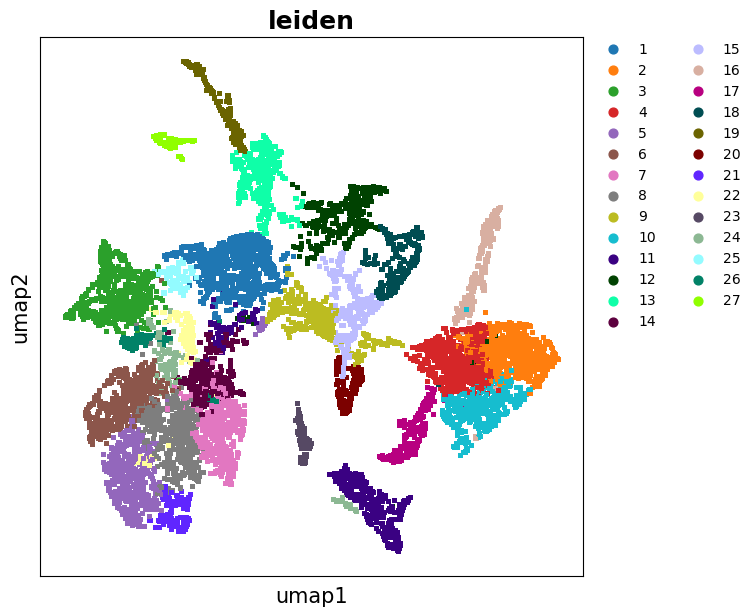

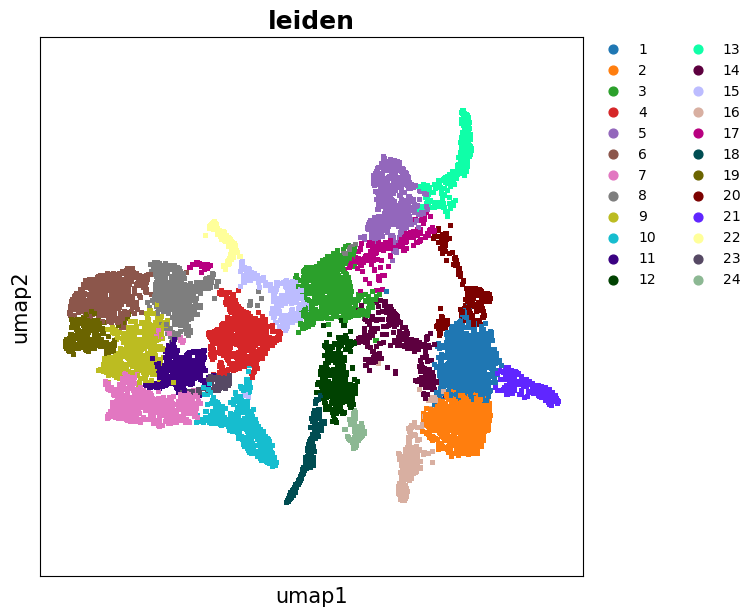

In [21]:
data_sct.plt.umap(res_key='umap', cluster_key='leiden', colors="glasbey_category10")
data.plt.umap(res_key='umap', cluster_key='leiden', colors="glasbey_category10")

In [93]:
sct_high_genes.tolist()[2920:2930]

['Smyd3',
 'Prkag2',
 'Ntf5',
 'Akt3',
 'Ldha',
 '2310040G24Rik',
 'Casp8',
 'Gm41293',
 'Gm37915',
 'Opn5']

<AxesSubplot:xlabel='umap1', ylabel='umap2'>

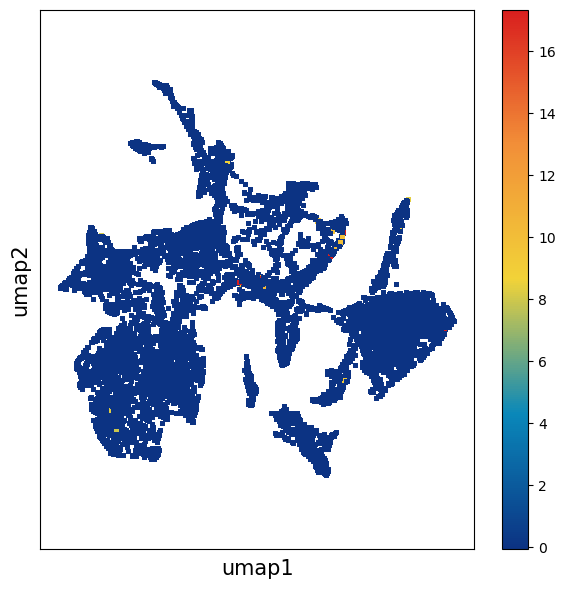

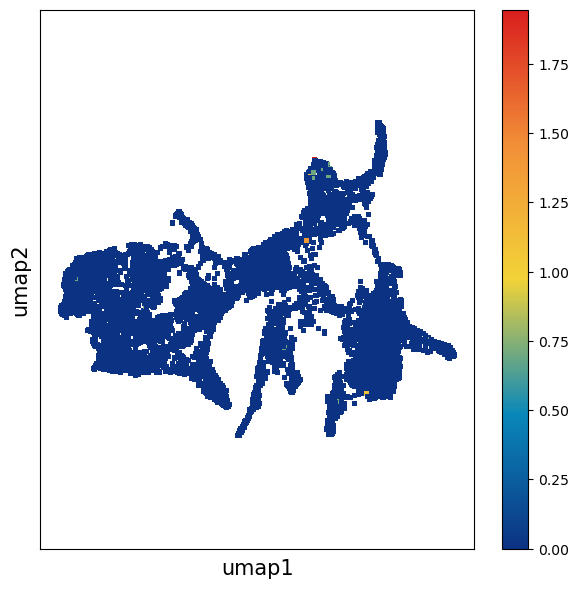

In [91]:
data_sct.plt.umap(res_key='umap', gene_names=['Ptgdr'])
data.plt.umap(res_key='umap', gene_names=['Ptgdr'])

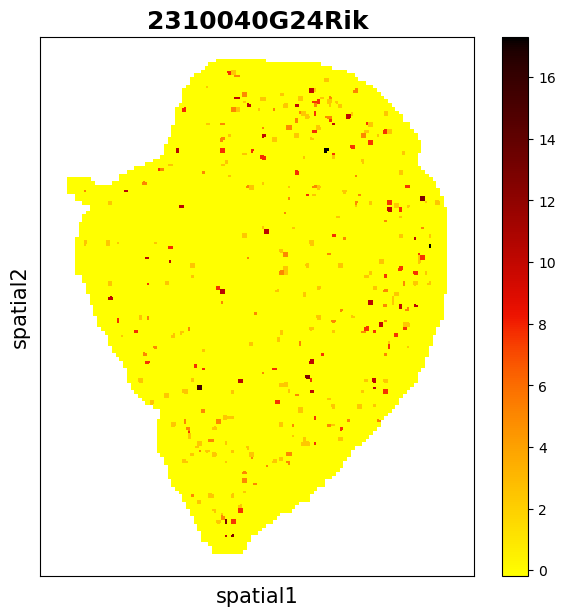

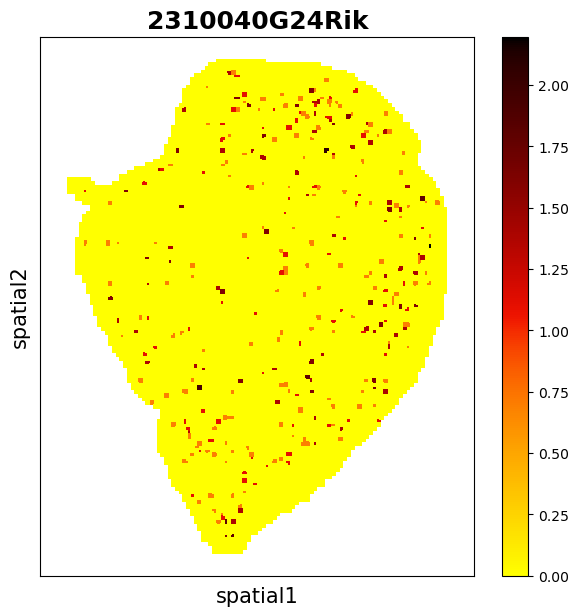

In [94]:
data_sct.plt.spatial_scatter_by_gene(gene_name='2310040G24Rik')
data.plt.spatial_scatter_by_gene(gene_name='2310040G24Rik')

<AxesSubplot:>

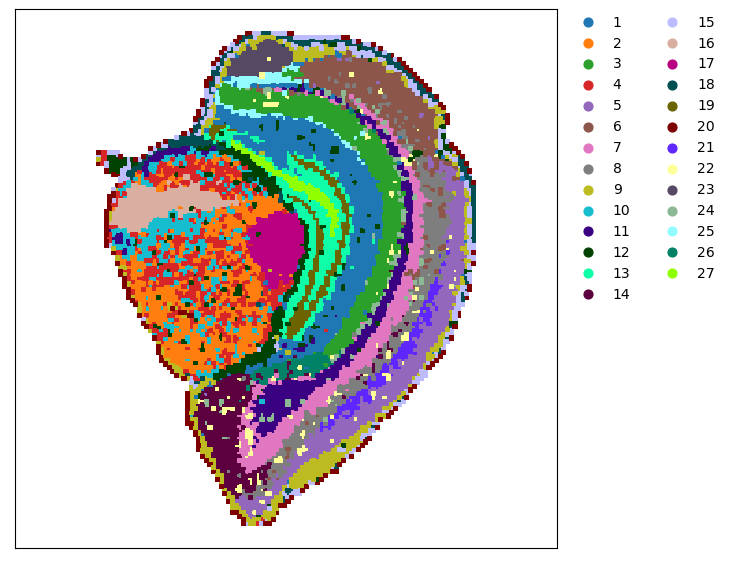

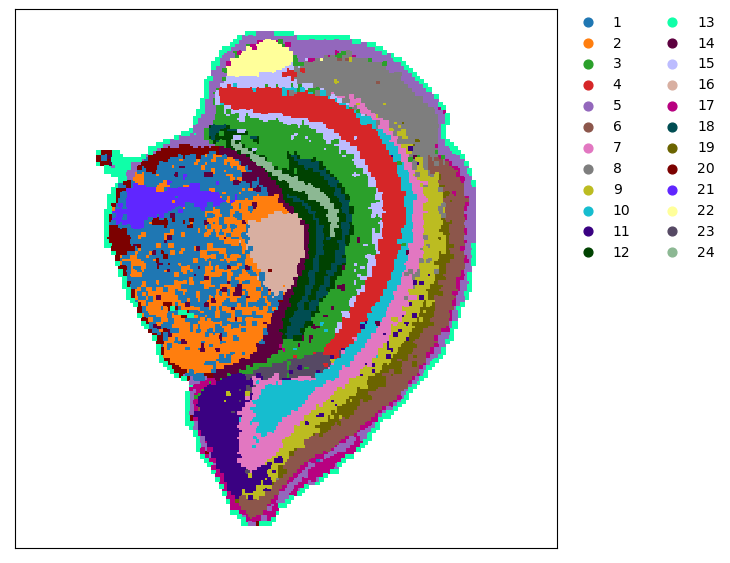

In [49]:
data_sct.plt.cluster_scatter(res_key='leiden', colors="glasbey_category10")
data.plt.cluster_scatter(res_key='leiden', colors="glasbey_category10")